# Testing it with various models

## Import all the things we need

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
from qutip import*
from scipy import *
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import cluster as clu
import time

Set up the connector

In [2]:
def CovertToSolver(y,t):
    n=len(y)//2
    yc=y[0:n]+1j*y[n:2*n]
    clu.SetCurrentValue(data,yc.tolist()) 
    dydtc=clu.CalEvolution(data)
    dydt=np.hstack((np.real(dydtc),np.imag(dydtc)))
    return dydt

## Testing it in Jaynes-Cumming model

With the rotating-wave approximation

$$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$$

### Build up the qutip version

In [3]:
wc = 1.0  * 2 * pi  # cavity frequency
wa = 1.0  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
N = 15              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation

tlist = np.linspace(0,25,101)

In [4]:
# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))

# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())


In [5]:
c_ops = []

# cavity relaxation
rate1 = kappa * (1 + n_th_a)
c_ops.append(sqrt(rate1) * a)


rate2= kappa * n_th_a
c_ops.append(sqrt(rate2) * a.dag())

# qubit relaxation
rate3 = gamma
c_ops.append(sqrt(rate3) * sm)

In [6]:
tic=time.time()
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])
toc=time.time()
t_qutip=toc-tic

In [7]:
n_c = output.expect[0]
n_a = output.expect[1]

### Build up the cluster version

In [8]:
Hamilton=[[1,2],[3,4],[1,4],[2,3]];print(Hamilton)
Hc=[wc,wa,g,g];print(Hc)
Co_ps=[[2],[1],[4]];print(Co_ps)
Cc=[rate1,rate2,rate3];print(Cc)
T_o=[[1,2],[3,4]];print(T_o)

[[1, 2], [3, 4], [1, 4], [2, 3]]
[6.283185307179586, 6.283185307179586, 0.3141592653589793, 0.3141592653589793]
[[2], [1], [4]]
[0.005, 0.0, 0.05]
[[1, 2], [3, 4]]


In [9]:
data=clu.DeriveAssign([0,1],Hamilton,Hc,Co_ps,Cc,T_o,2)

In [10]:
y0c=np.array(clu.GetCurrentValue(data))
y0=np.hstack((np.real(y0c),np.imag(y0c)))
tic=time.time()
sol2=odeint(CovertToSolver,y0,tlist)
toc=time.time()
t_cluster=toc-tic

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

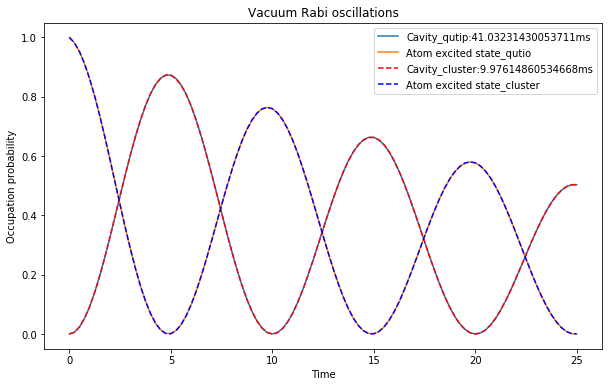

In [11]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,6))

axes1.plot(tlist, n_c,label="Cavity_qutip:"+str(1000*t_qutip)+'ms')
axes1.plot(tlist, n_a,label="Atom excited state_qutio")
axes1.plot(tlist, sol2[...,0],color='red',linestyle='--',label="Cavity_cluster:"+str(1000*t_cluster)+'ms')
axes1.plot(tlist, sol2[...,1],color='blue',linestyle='--',label="Atom excited state_cluster")
axes1.legend(loc=0)
axes1.set_xlabel('Time')
axes1.set_ylabel('Occupation probability')
axes1.set_title('Vacuum Rabi oscillations')